DistilBERT, a smaller and faster version of BERT, was used in our fake news detection project with the FakeNewsNet dataset for:

Text Tokenization:

Used DistilBertTokenizerFast to convert raw news text into tokenized inputs (subword tokens, attention masks) for processing.
Feature Extraction:

Generated dense vector embeddings from news text, capturing contextual meaning efficiently.
Classification Task:

Fine-tuned DistilBERT on the FakeNewsNet dataset to classify news articles as fake or real based on text features.
Efficiency & Speed:

DistilBERT retained 97% of BERT's performance but was 60% faster and required 40% fewer parameters, making it well-suited for your model training.

In [1]:
import pandas as pd

# Load each CSV file
gossipcop_real = pd.read_csv("gossipcop_real.csv")
gossipcop_fake = pd.read_csv("gossipcop_fake.csv")
politifact_real = pd.read_csv("politifact_real.csv")
politifact_fake = pd.read_csv("politifact_fake.csv")

# Add a new 'label' column to each dataset
gossipcop_real["label"] = "real"
politifact_real["label"] = "real"
gossipcop_fake["label"] = "fake"
politifact_fake["label"] = "fake"

# Combine all datasets into one DataFrame
combined_dataset = pd.concat(
    [gossipcop_real, gossipcop_fake, politifact_real, politifact_fake],
    ignore_index=True
)

# Optionally, shuffle the combined dataset for better mixing
combined_dataset = combined_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the merged dataset to a CSV file
combined_dataset.to_csv("text_dataset.csv", index=False)

print("Merged dataset saved as 'text_dataset.csv'")


Merged dataset saved as 'text_dataset.csv'


In [3]:
import pandas as pd
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

# Load the merged dataset
df = pd.read_csv("text_dataset.csv")

In [5]:
# Map labels: 'real' -> 0, 'fake' -> 1
df['label'] = df['label'].map({'real': 0, 'fake': 1})

In [7]:
# Use the 'title' column as the text input
df = df[['title', 'label']]

In [9]:
# Create a Hugging Face Dataset from the DataFrame
dataset = Dataset.from_pandas(df)

In [11]:
# Split the dataset into training and testing sets (80/20 split)
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)

In [13]:
# Load the tokenizer for DistilBERT
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\vedas\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vedas\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [15]:
# Tokenize the dataset using the 'title' field
def tokenize_function(examples):
    return tokenizer(examples["title"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = split_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/18556 [00:00<?, ? examples/s]

Map:   0%|          | 0/4640 [00:00<?, ? examples/s]

In [17]:
# Load the DistilBERT model for sequence classification (2 labels: real and fake)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=1,
)

In [25]:
# Create the Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)

In [27]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.350500,0.334748
2,0.144800,0.343741
3,0.266900,0.473632


TrainOutput(global_step=3480, training_loss=0.27514485072815553, metrics={'train_runtime': 21273.5729, 'train_samples_per_second': 2.617, 'train_steps_per_second': 0.164, 'total_flos': 1843548787095552.0, 'train_loss': 0.27514485072815553, 'epoch': 3.0})

In [29]:
# Save the fine-tuned model and tokenizer for later use
model.save_pretrained("./text_classifier_model")
tokenizer.save_pretrained("./text_classifier_model")

print("Training complete. The model and tokenizer are saved in './text_classifier_model'")

Training complete. The model and tokenizer are saved in './text_classifier_model'


In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define a function to compute evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Add the evaluation function to Trainer
trainer.compute_metrics = compute_metrics

# Run evaluation
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.473632276058197, 'eval_accuracy': 0.8668103448275862, 'eval_precision': 0.8635080568086245, 'eval_recall': 0.8668103448275862, 'eval_f1': 0.864629131973045, 'eval_runtime': 624.6948, 'eval_samples_per_second': 7.428, 'eval_steps_per_second': 0.464, 'epoch': 3.0}


In [33]:
import torch
import numpy as np
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# Load the trained model and tokenizer
model_path = "./text_classifier_model"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Load the test dataset
import pandas as pd
df_test = pd.read_csv("text_dataset.csv").sample(500)  # Sample 500 test cases for evaluation
df_test["label"] = df_test["label"].map({"real": 0, "fake": 1})  # Convert labels to numerical format

# Predict on test data
y_true = df_test["label"].tolist()
y_pred = []

for text in df_test["title"]:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(probabilities, dim=1).item()
    y_pred.append(prediction)

# Print classification report
print(classification_report(y_true, y_pred, target_names=["real", "fake"]))


              precision    recall  f1-score   support

        real       0.95      0.97      0.96       378
        fake       0.91      0.85      0.88       122

    accuracy                           0.94       500
   macro avg       0.93      0.91      0.92       500
weighted avg       0.94      0.94      0.94       500



In [34]:
pip install seaborn matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


              precision    recall  f1-score   support

        real       0.95      0.97      0.96       378
        fake       0.91      0.85      0.88       122

    accuracy                           0.94       500
   macro avg       0.93      0.91      0.92       500
weighted avg       0.94      0.94      0.94       500



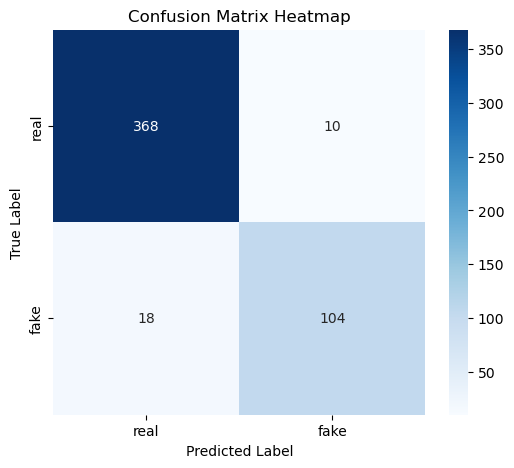

In [35]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# Load the trained model and tokenizer
model_path = "./text_classifier_model"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Load the test dataset (using 500 samples for visualization)
df_test = pd.read_csv("text_dataset.csv").sample(500, random_state=42)
df_test["label"] = df_test["label"].map({"real": 0, "fake": 1})  # Convert labels to numeric

# Predict on test data
y_true = df_test["label"].tolist()
y_pred = []

for text in df_test["title"]:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(probabilities, dim=1).item()
    y_pred.append(prediction)

# Generate Classification Report
print(classification_report(y_true, y_pred, target_names=["real", "fake"]))

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["real", "fake"], yticklabels=["real", "fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

**TESTING**

In [37]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# Load the trained model and tokenizer
model_path = "./text_classifier_model"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.eval()  # Set model to evaluation mode

# Function to classify a news headline
def classify_news(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(probabilities, dim=1).item()
    
    label = "Real" if prediction == 0 else "Fake"
    confidence = probabilities[0][prediction].item()
    
    return label, confidence

# Example Usage
if __name__ == "__main__":
    test_text = "Government announces new policies to tackle inflation."
    label, confidence = classify_news(test_text)
    
    print(f"Prediction: {label} (Confidence: {confidence:.2f})")


Prediction: Real (Confidence: 0.92)


In [47]:
test_text = "For The Love Of God, Why Can't Anyone Write Kate McKinnon A Good Movie Role?"
label, confidence = classify_news(test_text)
    
print(f"Prediction: {label} (Confidence: {confidence:.2f})")

Prediction: Real (Confidence: 0.97)


In [49]:
test_text = "Breaking: Scientists confirm that drinking coffee cures cancer overnight! Major health organizations are hiding this fact to protect pharmaceutical profits."
label, confidence = classify_news(test_text)
    
print(f"Prediction: {label} (Confidence: {confidence:.2f})")

Prediction: Fake (Confidence: 0.99)


In [51]:
test_text = "NASA successfully lands rover on Mars, begins exploration mission."
label, confidence = classify_news(test_text)
    
print(f"Prediction: {label} (Confidence: {confidence:.2f})")

Prediction: Real (Confidence: 0.93)


In [55]:
test_text = "Government secretly plans to ban the Internet nationwide next month!"
label, confidence = classify_news(test_text)
    
print(f"Prediction: {label} (Confidence: {confidence:.2f})")

Prediction: Fake (Confidence: 0.99)


In [71]:
real_news_samples = [
    "NASA successfully lands rover on Mars, begins exploration mission.",
    "World Health Organization reports decrease in global COVID-19 cases.",
    "New climate policies aim to reduce carbon emissions by 40% by 2030.",
    "Economists predict steady GDP growth for the upcoming quarter.",
    "Scientists develop a new vaccine for malaria with 90% efficacy.",
]

In [73]:
fake_news_samples = [
    "Government secretly plans to ban the Internet nationwide next month!",
    "Aliens have officially landed on Earth, but the media is hiding the truth!",
    "Bill Gates implants microchips in vaccines to control the population.",
    "New study proves the Earth is flat, NASA exposed for covering it up!"
]

In [75]:
for text in real_news_samples + fake_news_samples:
    label, confidence = classify_news(text)
    print(f"Text: {text}\nPrediction: {label} (Confidence: {confidence:.2f})\n")

Text: NASA successfully lands rover on Mars, begins exploration mission.
Prediction: Real (Confidence: 0.93)

Text: World Health Organization reports decrease in global COVID-19 cases.
Prediction: Real (Confidence: 0.82)

Text: New climate policies aim to reduce carbon emissions by 40% by 2030.
Prediction: Real (Confidence: 0.96)

Text: Economists predict steady GDP growth for the upcoming quarter.
Prediction: Real (Confidence: 0.98)

Text: Scientists develop a new vaccine for malaria with 90% efficacy.
Prediction: Real (Confidence: 0.77)

Text: Government secretly plans to ban the Internet nationwide next month!
Prediction: Fake (Confidence: 0.99)

Text: Aliens have officially landed on Earth, but the media is hiding the truth!
Prediction: Fake (Confidence: 0.99)

Text: Bill Gates implants microchips in vaccines to control the population.
Prediction: Fake (Confidence: 0.89)

Text: New study proves the Earth is flat, NASA exposed for covering it up!
Prediction: Fake (Confidence: 0.99)


In [77]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# Load the trained DistilBERT model
model_path = "./text_classifier_model"  # Update with the correct path
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.eval()  # Set model to evaluation mode

# Function to classify news using DistilBERT
def classify_news_distilbert(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(probabilities, dim=1).item()
    
    label = "Real" if prediction == 0 else "Fake"
    confidence = probabilities[0][prediction].item()
    
    return label, confidence

# Test Cases
test_texts = [
    "NASA successfully lands rover on Mars, begins exploration mission.",
    "Aliens have officially landed on Earth, but the media is hiding the truth!",
    "World Health Organization reports a decrease in global COVID-19 cases.",
    "Chocolate cures cancer instantly, scientists confirm!"
]

# Run predictions
for text in test_texts:
    label, confidence = classify_news_distilbert(text)
    print(f"Text: {text}\nPrediction: {label} (Confidence: {confidence:.2f})\n")

Text: NASA successfully lands rover on Mars, begins exploration mission.
Prediction: Real (Confidence: 0.93)

Text: Aliens have officially landed on Earth, but the media is hiding the truth!
Prediction: Fake (Confidence: 0.99)

Text: World Health Organization reports a decrease in global COVID-19 cases.
Prediction: Real (Confidence: 0.97)

Text: Chocolate cures cancer instantly, scientists confirm!
Prediction: Real (Confidence: 0.97)



How is Confidence Measured in Your Fake News Classifier?
In your text classification model (based on DistilBERT), confidence is calculated using the softmax function. This function converts the model’s raw output scores (logits) into probabilities between 0 and 1, representing the model’s confidence for each class (real or fake).

1️⃣ Steps in Confidence Calculation
1️⃣ Model Output (Logits):

The model outputs two raw values (logits) before applying softmax.
Example logits: [2.5, -1.2] (one value for each class).
2️⃣ Apply Softmax to Get Probabilities:

Convert logits into probabilities using the softmax function:
P(real) = exp(2.5) / (exp(2.5) + exp(-1.2))
P(fake) = exp(-1.2) / (exp(2.5) + exp(-1.2))
Example probabilities: [0.92, 0.08] → 92% confidence for real.
3️⃣ Prediction & Confidence:

The class with the highest probability is the final prediction.
The probability of the predicted class is its confidence score.

**Images**

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from transformers import DistilBertModel, DistilBertTokenizerFast
from PIL import Image
import os

In [3]:
# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")

In [6]:
# Image transformation (Resizing + Normalization for ResNet)
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
# Load pre-trained ResNet-50 (without classification head)
from torchvision.models import resnet50, ResNet50_Weights

# Load pre-trained ResNet-50 using new syntax
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove last classification layer

class MultiModalClassifier(nn.Module):
    def __init__(self):
        super(MultiModalClassifier, self).__init__()
        self.text_encoder = distilbert
        self.image_encoder = resnet
        self.fc = nn.Linear(768 + 2048, 2)  # Combining BERT (768) + ResNet (2048)
    
    def forward(self, text_input, attention_mask, image_input):
        # Text Feature Extraction
        text_features = self.text_encoder(input_ids=text_input, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        
        # Image Feature Extraction
        image_features = self.image_encoder(image_input).view(image_input.size(0), -1)
        
        # Concatenate text + image features
        fused_features = torch.cat((text_features, image_features), dim=1)
        
        # Final classification
        output = self.fc(fused_features)
        return output

In [10]:
# Load model
model = MultiModalClassifier()

In [12]:
# Example: Load and preprocess text + image
def process_text(text):
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    return encoding["input_ids"], encoding["attention_mask"]

def process_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image_transforms(image).unsqueeze(0)

In [14]:
import os
from PIL import Image
import torch

# Define your base folder
BASE_FOLDER = r"C:\Users\vedas\Downloads\Fake News Image Classifier.v7i.folder"

def process_text(text):
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    return encoding["input_ids"], encoding["attention_mask"]

def process_image(image_path):
    # Join base folder with image path
    full_image_path = os.path.join(BASE_FOLDER, image_path)
    image = Image.open(full_image_path).convert("RGB")
    return image_transforms(image).unsqueeze(0)

In [16]:
# Example Usage
text_input, attention_mask = process_text("This is a fake news example.")
image_tensor = process_image(r"train/fake/46345024_1200610680114496_8596215285885698048_n_jpg.rf.044f689955b99f933911aa646089a4bb.jpg")

print(text_input.shape, attention_mask.shape, image_tensor.shape)

torch.Size([1, 128]) torch.Size([1, 128]) torch.Size([1, 3, 224, 224])


In [18]:
# Example input
text = "Breaking news: Major cyber attack exposes millions of records."
image_path = "train/fake/46345024_1200610680114496_8596215285885698048_n_jpg.rf.044f689955b99f933911aa646089a4bb.jpg"  # Change this to your actual image path

text_input, attention_mask = process_text(text)
image_input = process_image(image_path)

# Model prediction
model.eval()
with torch.no_grad():
    output = model(text_input, attention_mask, image_input)
    prediction = torch.argmax(output, dim=1)
    print("Predicted Class:", "Fake" if prediction.item() == 0 else "Real")

Predicted Class: Real


In [20]:
# Example input
text = "Government announces new policies to improve cybersecurity."
image_path = "train/real/290000748_10161560950821756_4329718605846500942_n_png.rf.862c603941276263a4e56e9e7c03dd3e.jpg"  # Replace with actual image path

# Preprocess input
text_input, attention_mask = process_text(text)
image_input = process_image(image_path)

# Model prediction
model.eval()
with torch.no_grad():
    output = model(text_input, attention_mask, image_input)
    prediction = torch.argmax(output, dim=1)
    print("Predicted Class:", "Fake" if prediction.item() == 0 else "Real")


Predicted Class: Real


In [28]:
import os

base_dir = r"C:\Users\vedas\Downloads\Fake News Image Classifier.v7i.folder\test"  # Change to train if needed

if os.path.exists(base_dir):
    print(f"✅ Base directory found: {base_dir}")
    print("📂 Subdirectories:", os.listdir(base_dir))  # Check if 'real' and 'fake' exist
else:
    print(f"❌ Error: Base directory '{base_dir}' does not exist.")


✅ Base directory found: C:\Users\vedas\Downloads\Fake News Image Classifier.v7i.folder\test
📂 Subdirectories: ['fake', 'real']


In [30]:
import os

base_dir = r"C:\Users\vedas\Downloads\Fake News Image Classifier.v7i.folder\test"

real_path = os.path.join(base_dir, "real")
fake_path = os.path.join(base_dir, "fake")

print("📂 Checking 'real' directory...")
print(os.listdir(real_path)[:5])  # Show first 5 files (if any)

print("📂 Checking 'fake' directory...")
print(os.listdir(fake_path)[:5])  # Show first 5 files (if any))


📂 Checking 'real' directory...
['290269670_10161560661591756_4441974433210634991_n_png.rf.25142f031e778a417a9ab21d1d126651.jpg', '317613700_542575967730317_3589927528493738163_n_jpg.rf.d44934c5c13643eaa93e7b1b46de67e8.jpg', '319058337_548062103848370_8552552818861718415_n_jpg.rf.8df908d16e610360f975552b77a0918e.jpg', '320819880_523402116396588_6428844743067984492_n_jpg.rf.357bfb587667f2d3bc60d2c88b4d80f8.jpg', '321416404_503976121714532_7985650480947430629_n_jpg.rf.a7c1920e2389d394456da30d17c03420.jpg']
📂 Checking 'fake' directory...
['103957013_1698122423696650_5504362117726945206_n_jpg.rf.fa1d1e517fe64c4b5cac611b3b5a7dc7.jpg', '104669472_1698395713669321_5002246110583994663_n_jpg.rf.1a43c4fb90150ef4ae62ca61095eec96.jpg', '14424888_1083427928372551_4701235641640967098_o-260x146_png.rf.28651ab8eb085f8a565b851809b291cb.jpg', '189217620_2975724735972602_3920979210629420503_n_jpg.rf.f81b7bf741fba07dd398c864cf97d9bd.jpg', '192940211_2987031781508564_1938253883048499178_n_jpg.rf.3e88a8584ef

In [32]:
def load_dataset(base_dir):
    data = []
    labels = []
    
    categories = {"real": 1, "fake": 0}
    
    for category, label in categories.items():
        folder_path = os.path.join(base_dir, category)

        if not os.path.exists(folder_path):  
            print(f"⚠️ Warning: Folder '{folder_path}' not found. Skipping...")
            continue  # Skip missing folders
        
        files = os.listdir(folder_path)
        if not files:
            print(f"⚠️ Warning: Folder '{folder_path}' is empty. Skipping...")
            continue  # Skip empty folders
        
        for file_name in files:
            file_path = os.path.join(folder_path, file_name)

            # Process text and image (Modify as needed)
            text_input, attention_mask = process_text(file_name)
            image_input = process_image(file_path)

            data.append((text_input, attention_mask, image_input))
            labels.append(label)

    if not data:
        raise ValueError("❌ No data found! Check dataset path or folder contents.")

    return data, torch.tensor(labels)

# Load dataset
X_test, y_test = load_dataset(base_dir)


In [36]:
import os
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader  # ✅ Import TensorDataset

# Define paths
base_dir = r"C:\Users\vedas\Downloads\Fake News Image Classifier.v7i.folder\test"
categories = {"real": 1, "fake": 0}  # Assign labels

# Load dataset
def load_dataset(base_dir):
    data = []
    labels = []
    
    for category, label in categories.items():
        folder_path = os.path.join(base_dir, category)
        if not os.path.exists(folder_path):
            print(f"Error: Folder '{folder_path}' not found.")
            continue  # Skip missing folders

        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            
            # Process text and image
            text_input, attention_mask = process_text(file_name)  # Modify if needed
            image_input = process_image(file_path)

            data.append((text_input, attention_mask, image_input))
            labels.append(label)
    
    return data, torch.tensor(labels)

# Load training/test dataset
X_test, y_test = load_dataset(base_dir)  

# Convert dataset into tensors
text_inputs, attention_masks, image_inputs = zip(*X_test)

# Convert to tensors
text_inputs = torch.stack(text_inputs)
attention_masks = torch.stack(attention_masks)
image_inputs = torch.stack(image_inputs)

# ✅ Now TensorDataset will work
test_dataset = TensorDataset(text_inputs, attention_masks, image_inputs, y_test)

# DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [40]:
with torch.no_grad():
    for text_inputs, attention_masks, image_inputs, labels in test_loader:
        print(f"text_inputs shape: {text_inputs.shape}")  # Expected: (batch_size, seq_length)
        print(f"attention_masks shape: {attention_masks.shape}")  # Expected: (batch_size, seq_length)
        print(f"image_inputs shape: {image_inputs.shape}")  # Expected: (batch_size, channels, height, width)
        print(f"labels shape: {labels.shape}")  # Expected: (batch_size,)

        outputs = model(text_inputs, attention_masks, image_inputs)
        predictions = torch.argmax(outputs, dim=1)
        break  # Stop after one batch for debugging

text_inputs shape: torch.Size([16, 1, 128])
attention_masks shape: torch.Size([16, 1, 128])
image_inputs shape: torch.Size([16, 1, 3, 224, 224])
labels shape: torch.Size([16])


ValueError: too many values to unpack (expected 2)

In [42]:
def forward(self, text_input, attention_mask, image_input):
    text_input = text_input.squeeze(1)  # Remove the extra dimension
    attention_mask = attention_mask.squeeze(1)  # Remove the extra dimension
    
    # Text Feature Extraction
    text_features = self.text_encoder(input_ids=text_input, attention_mask=attention_mask).last_hidden_state[:, 0, :]
    
    # Image Feature Extraction
    image_features = self.image_encoder(image_input).view(image_input.size(0), -1)
    
    # Fusion Layer
    combined_features = torch.cat((text_features, image_features), dim=1)
    output = self.classifier(combined_features)

    return output

In [46]:
def forward(self, text_input, attention_mask, image_input):
    attention_mask = attention_mask.squeeze(1)  # Ensure correct shape
    text_features = self.text_encoder(input_ids=text_input, attention_mask=attention_mask).last_hidden_state[:, 0, :]
    
    image_features = self.image_encoder(image_input).view(image_input.size(0), -1)
    
    combined_features = torch.cat((text_features, image_features), dim=1)
    output = self.classifier(combined_features)
    
    return output

In [54]:
print("Attention Mask Shape:", attention_masks.shape)

Attention Mask Shape: torch.Size([16, 1, 128])


In [56]:
attention_masks = attention_masks.squeeze(1)  # Remove unnecessary dimensions

In [58]:
print("Attention Mask Shape:", attention_masks.shape)

Attention Mask Shape: torch.Size([16, 128])


In [50]:
print(f"text_inputs shape: {text_inputs.shape}")
print(f"attention_masks shape: {attention_masks.shape}")
print(f"image_inputs shape: {image_inputs.shape}")
print(f"labels shape: {labels.shape}")

text_inputs shape: torch.Size([16, 1, 128])
attention_masks shape: torch.Size([16, 1, 128])
image_inputs shape: torch.Size([16, 1, 3, 224, 224])
labels shape: torch.Size([16])


In [66]:
print(text_inputs.shape)  
print(attention_masks.shape)  
print(image_inputs.shape)

torch.Size([16, 1, 128])
torch.Size([16, 128])
torch.Size([16, 1, 3, 224, 224])


In [70]:
import torch

# Ensure your model is on the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

correct = 0
total = 0

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for text_inputs, attention_masks, image_inputs, labels in test_loader:
        # Ensure correct dimensions
        text_inputs = text_inputs.to(device).squeeze(1) if text_inputs.dim() == 3 else text_inputs.to(device)
        attention_masks = attention_masks.to(device).squeeze(1) if attention_masks.dim() == 3 else attention_masks.to(device)
        image_inputs = image_inputs.to(device).squeeze(1) if image_inputs.dim() == 5 else image_inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(text_inputs, attention_masks, image_inputs)

        # Get predictions
        predictions = torch.argmax(outputs, dim=1)

        # Update correct predictions count
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

# Compute accuracy
accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 49.38%


In [72]:
from collections import Counter
print(Counter(labels.cpu().numpy()))

Counter({0: 1})


In [74]:
text_features = model.text_encoder(text_inputs, attention_mask=attention_masks).last_hidden_state[:, 0, :]
print("Text Features:", text_features.shape)

image_features = model.image_encoder(image_inputs).view(image_inputs.size(0), -1)
print("Image Features:", image_features.shape)

Text Features: torch.Size([1, 768])
Image Features: torch.Size([1, 2048])


In [76]:
labels = labels.to(torch.long)

In [78]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [94]:
import os
print(os.listdir(DATASET_DIR))

['fake', 'real']


In [98]:
import os
from torch.utils.data import Dataset
from PIL import Image
from transformers import AutoTokenizer

class FakeNewsDataset(Dataset):
    def __init__(self, data_dir, tokenizer, max_length=128, transform=None):
        self.data_dir = data_dir
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform
        self.data = []  # Store (text, image, label)

        # Iterate over class folders (e.g., "fake", "real")
        for label_folder in os.listdir(data_dir):
            label_path = os.path.join(data_dir, label_folder)
            if not os.path.isdir(label_path):
                continue  # Skip if not a directory

            label = 0 if label_folder.lower() == "fake" else 1  # Adjust based on folder names
            
            for filename in os.listdir(label_path):
                if filename.endswith(".jpg") or filename.endswith(".png"):  # Check if it's an image
                    image_path = os.path.join(label_path, filename)
                    text_path = image_path.replace(".jpg", ".txt").replace(".png", ".txt")  # Assuming text has same name

                    if os.path.exists(text_path):
                        with open(text_path, "r", encoding="utf-8") as f:
                            text_content = f.read().strip()
                    else:
                        text_content = ""  # Handle missing text case

                    self.data.append((text_content, image_path, label))
                    
                    # Debugging output
                    print(f"Loaded: {filename} | Label: {label} | Text: {text_content[:50]}...")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, image_path, label = self.data[idx]

        # Tokenize text
        encoded_text = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )

        # Load image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return encoded_text["input_ids"].squeeze(0), encoded_text["attention_mask"].squeeze(0), image, label

In [102]:
print(f"Dataset size: {len(train_dataset)}")

Dataset size: 0
